<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S32_vacuum_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import gtsam

import gtbook
import gtbook.display
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs): 
    return gtbook.display.show(obj, VARIABLES, **kwargs)

# From section 3.1:
rooms = ["Living Room", "Kitchen", "Office", "Hallway", "Dining Room"]
X = VARIABLES.discrete_series("X", [1], rooms)
state_prior = gtsam.DiscreteDistribution(X[1], "0/0/1/0/0")

# Actions over time

> Actions are not perfect.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [34]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(3, 2, "steampunk", 1))

In the real world, robots do not always execute actions perfectly, for a
variety of reasons. We can use discrete variables to model the state a
robot is in, and actions that connect these states. To model the
uncertainty with executing an action, we will once again use the
language of probability. As before we will use 
*conditional probability distributions* to model how we can affect the state 
of the robot by actions. 
We can model this graphically, using directed edges to specify conditional
probabilities on variables, and use simulation in a graphical model to
explore what a sequence of actions will yield as outcome. 
The graphical model approach allows us to easily extend probabilistic actions to
factored state representations.

## Probabilistic Outcomes of Actions

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/N3-Mud.png?raw=1" id="fig:Mud" style="width:14cm" alt="" />
<figcaption id="fig:Mud" label="fig:Mud">Mobile robot driving in mud.</figcaption>
</figure>

In the real world, robots do not always execute actions perfectly, for a
variety of reasons. For example, as shown in Figure
<a href="#fig:Mud" data-reference-type="ref" data-reference="fig:Mud">1</a>,
a robot may want to drive forwards in an outdoor environment but mud
under its wheels might prevent it from traveling as far as we would
like.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/N3-Pick.png?raw=1" id="fig:Pickup" style="width:14cm" alt="" />
<figcaption id="fig:Pickup" label="fig:Pickup">A humanoid attempting to pick up an object.</figcaption>
</figure>

Or a robot with an articulated arm (Figure
<a href="#fig:Pickup" data-reference-type="ref" data-reference="fig:Pickup">2</a>)
might attempt picking up an object, but fail. 

## Navigation Actions
<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/S32-Actions.png?raw=1" id="fig:Stochastic" style="width:14cm" alt="" />
<figcaption id="fig:Stochastic" label="fig:Stochastic">In our abstracted floor plan, actions attempted to the robot (Left, right, Up, and Down), might or might not succeed.</figcaption>
</figure>

Our hypothetical vacuum robot can take actions that succeed probabilistically. Abstracting the floor plan from the previous section, let us model this vacuum robot as moving between the five rooms in the floor plan. We have already discussed the state space in the previous section. The **action space** is simple: the robot can choose to go left (L), right (R), up (U), or down (D), schematically shown in Figure <a href="#fig:Vacuum" data-reference-type="ref" data-reference="fig:Vacuum">1</a>. However, a variety of things could go wrong: a particular doorway might be blocked, the robot might get lost, or it might take an action that is simply not available in a particular room - for example going from the office to the living room directly.

To model the uncertainty associated with executing an action, we will once again use the language of probability. 
In particular, we will now use conditional probability distributions to model how we can
affect the state of the robot by actions. We model the
effects of actions by the **state transition model** $P(X_{t+1}|X_{t}=x,A=a)$ on the next state $X_{t+1}$, 
given the value
$x$ of the current state $X_{t}$, and the value $a$ of the action $A$. Because the state space in this case involves navigation, we also call the corresponding conditional distribution $P(X_{t+1}|X_{t},A)$ a **motion model**.

The code below creates a motion model for moving from state $X_1$ to $X_2$:

In [35]:
actions = ["L","R","U","D",]
A = VARIABLES.discrete_series("A", [1, 2], actions)
X = VARIABLES.discrete_series("X", [1, 2, 3], rooms)
spec = """
    1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
    8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 2/0/0/0/8
    0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
    0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
    0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1
    """
motion_model = gtsam.DiscreteConditional(X[2], [X[1], A[1]], spec)
pretty(motion_model)

X1,A1,Living Room,Kitchen,Office,Hallway,Dining Room
Living Room,L,1,0,0,0,0
Living Room,R,0.2,0.8,0,0,0
Living Room,U,1,0,0,0,0
Living Room,D,0.2,0,0,0.8,0
Kitchen,L,0.8,0.2,0,0,0
Kitchen,R,0,1,0,0,0
Kitchen,U,0,1,0,0,0
Kitchen,D,0.2,0,0,0,0.8
Office,L,0,0,1,0,0
Office,R,0,0,0.2,0.8,0


It is of course very tedious to specify this table by hand: it has $5*5*4=100$ entries, because for every one of the 5 rooms in the house we have to specify what happens for every one of the 4 possible actions. To specify what happens we need 5 numbers that have to add up to one, because the robot has to end up *somewhere*. In the example above, we specified impossible actions to have no effect (with 100% certainty), whereas allowable actions succeed with 80% chance of success.

Conditional probability distributions do not *have* to be specified as giant
tables. Because the state space is potentially quite large, such a
motion model is almost never explicitly specified, but
rather exploits the semantics of the states and actions to calculate the conditional distribution at run-time.

### Exercises

1.  Even though the CPT above
    has 100 numbers in it, how many independent degrees of freedom do we
    actually have when specifying this CPT?

2.  Specify a parametric conditional density for the action models for
    the vacuuming robot that is somewhat realistic, yet not completely
    deterministic.

3.  It is possible to create models that do not reflect everyday
    physics. For example, how could we model the game “Portal”?

## A Simple Graphical Model

Graphically, we can represent a probability mass function (PMF) over a
single random variable $X$ as a single node, with the label $X$, and we can 
use directed edges to specify conditional probabilities on
variables. As an application, we can use this simple graphical model to represent
the probabilistic transitions between states, as shown below:

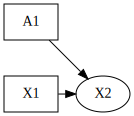

In [36]:
action_prior = gtsam.DiscreteDistribution(A[1], "1/1/1/1")
fragment = gtsam.DiscreteBayesNet()
fragment.add(motion_model)
show(fragment, hints={"A":2, "X":1}, boxes={A[1][0], X[1][0]})

In the graph above, we indicate by the *boxes* those values thar are *assumed known*. To evaluate the probability of $P(X_2|X_1,A_1)$, we *need* to know what the conditioning variables $X_1$ and $A_1$ are.

Given values for the parent variables, we can examine the corresponding transition probability. For example, if we start from the $X_1=\text{Hallway}$ and attempt to go right, i.e., action $A_0=\text{R}$, we retrieve the following PMF over the next state $X_2$:

In [37]:
values = VARIABLES.assignment({X[1]:"Hallway", A[1]: "R"})
pretty(motion_model.choose(values))

X2,value
Living Room,0
Kitchen,0
Office,0
Hallway,0.2
Dining Room,0.8


## Bayes Nets

>  Bayes nets provide a graphical language to string together several conditional probabilities into a generative world model.

A **Bayes net** is a directed *acyclic* graph (DAG) describing a factored
probability distribution a set of random variables. 
The joint
distribution on the set of all variables is given as

$$P(\{X_{i}\})=\prod_{i=1}^{n}P(X_{i}|\Pi_{i})$$ 

where $n$ is the number
of variables, and $\Pi_{i}$ denotes the set of parents for variable
$X_{i}$. An example of a Bayes net is shown in the Figure below,
and it is simply a graphical representation of which random variables’s
CPT depend on which other variables. In this case, the joint
distribution can be read off as

$$P(W,X,Y,Z)=P(W|X,Y)P(X|Y,Z)P(Y|Z)P(Z).$$

Note that the order in which
we multiply the conditionals does not matter, but we typically prefer to put the parents more towards the right, as above.

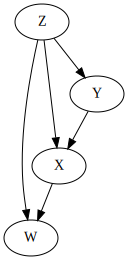

In [38]:
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")
show(wxyz)

Note that the above graph has cycles, but the cycles are only in the underlying *undirected* graph, not in the directed graph. Directed cycles, i.e. cycles with a consistent direction, are not allowed.

A Bayes net can be a very efficient representation of complex
probability distributions, as they encode the dependence and especially
independence relationships between the variables.
The Bayes net above was created assuming binary variables, and hence did not take
a lot of effort to specify, but as we saw above, even for relatively small state spaces 
the complexity of specifying CPTs can be daunting.

For example, if we
were to construct a full table of probabilities for each possible
outcome of the variables $W$,$X$,$Y$, and $Z$, the table could be quite
long. For example, if we assume they all have 10 possible values, then
the full joint has $10^{4}$ entries, i.e., $10,000$ unique values. You
can save a tiny bit, because they have to sum up to 1, so strictly
speaking we need only $9,999$ values. In contrast, we can tally how many
entries all four CPT tables have for the Bayes net above. 
In the table below we did just that:

|     CPT    | \# entries |
|-|-|
|   *P(Z)*   |      9     |
|  *P(Y\|Z)*  |     90     |
| *P(X\|Y,Z)* |     900    |
| *P(W\|X,Y)* |     900    |

For example, $P(X|Y,Z)$ has 900 entries, i.e., 9
(independent) entries for each of 100 possible combinations of $Y$ and
$Z$. Hence, the total number of parameters we need is only $1,899$,
which is way less than $9,999$.

## Markov Chains

> A Markov chain is a special kind of Bayes net.

A **Markov chain** is a graphical representation of repeated state
transitions. Indeed, by chaining transition probabilities together
we can create a Markov chain programmatically (try varying N):

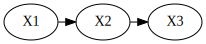

In [39]:
N = 3
X = VARIABLES.discrete_series("X", range(1, N+1), rooms)
markov_chain = gtsam.DiscreteBayesNet()
markov_chain.add(state_prior)
for k in range(1, N):
    markov_chain.add(X[k+1], [X[k]], "6/1/1/1/1 1/6/1/1/1 1/1/6/1/1 1/1/6/1/1 1/1/1/1/6 ")
show(markov_chain, hints={"X":1})

Every state $X_k$ only depends on the previous state $X_{k-1}$, a property known as the **Markov property**, hence the name.

## Markov Decision Processes

> An MDP chain is a Markov chain with actions added.

A **Markov Decision Process** or MDP is a graphical representation of repeated state transitions, given a known sequence of actions. 
This is the ideal representation to represent effects of actions on robot states, as in our example.
Indeed, by chaining the "action fragments" defined above together, we can create an MDP programmatically (try varying N):

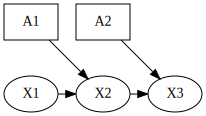

In [40]:
A = VARIABLES.discrete_series("A", range(1, N), actions)
bayesNet = gtsam.DiscreteBayesNet()
bayesNet.add(state_prior)
for k in range(1, N):
    bayesNet.add(X[k+1], [X[k], A[k]], spec) # add creates conditional and adds
show(bayesNet, hints={"A":2, "X":1}, boxes={A[1][0],A[2][0]})

In an MDP we assume we *know* the actions (hence the boxes!) and the hence the chain is really defined on the state variables $X$. Looking at the Bayes net above, the state variables $X_1$, $X_2$ and $X_3$ indeed form a Markov chain, albeit one where the transition matrix depends on the chosen action.

The joint distribution over the states $X$, *given* the action sequence $A$ is given by

$$P(X|A)=P(X_1)\prod_{k=2}^{N}P(X_k|A_k,X_{k-1})$$ 


While we know from the motion model given earlier where we expect to end up after one action,  it is less straightforward to calculate what our belief is after *two* actions. 
We will defer the exact calculation to the next Chapter, but in the next section we show how to get an approximate answer to that question via sampling.

## Forward Simulation

We can use simulation in a graphical model to explore what a sequence of
actions will yield as outcome. 
To sample from a *conditional* distribution $p(X|Y)$ we need to make
sure we sample the variable $Y$ beforehand, and then proceed simply by
selecting the appropriate PMF depending on the value of $Y$. We can then
proceed as before using the inverse transform sampling method.

Forward sampling in a Markov chain simply repeats these steps in
succession, proceeding from left to right. 
Simulating a robot *given* an initial state $X_1$ and 
sequence of actions $A_{1},A_{2},\ldots$ is then equivalent to sampling
from this Markov chain:

1.  Set $k=1$.

2.  Simulate the effect of the next action by sampling the next state
    $x_{k+1}$ from 
    
    $$P(X_{k+1}|X_{k}=x_{k},A_{k}=a_{k}).$$

3.  Increase $k$ and return to step $2$.

Below we show how to code this up and show  4 different “rollouts” by simulating in this way. After
that, we can approximate the PMF of the final state by construction a
histogram over the possible values of the state:

In [41]:
def sample(x1, a1, a2):
    values = VARIABLES.assignment({X[1]:x1, A[1]: a1})
    x2 = rooms[bayesNet.at(1).sample(values)]
    values = VARIABLES.assignment({X[2]:x2, A[2]: a2})
    x3 = rooms[bayesNet.at(2).sample(values)]
    return [x1, x1, x3]

for i in range(4):
    print(sample("Office", "R","U"))

['Office', 'Office', 'Living Room']
['Office', 'Office', 'Living Room']
['Office', 'Office', 'Living Room']
['Office', 'Office', 'Living Room']


While simple, simulating from a forward model is a rather important
technique, and underlies some of the recent successes in deep
reinforcement learning, as well as the success of DeepMind in beating
the world’s best players of the game of Go.

### Exercise

Generalize the above forward sampling algorithm to an arbitrary number of actions. Hint: you will have to make sure the variables are defined, and the Bayes Net is extended properly.

## Factored State Representations

Factored state representations are useful if the state of the robot can
be described using features that are relatively independent of each
other. Continuing our example, the robot vacuum cleaner might also run
out of battery power, so we could associate a different variable with
its battery status, e.g., `empty`, `half`, or `full`.
The state of the robot would then be specified by the combination of
these two variables. Note that now the total number of possible states
is combinatorial: if there are five rooms and three different battery
levels, we have a total of 15 possible states for the robot.

A possible model for battery life could be the following transition table, which is independent of which action was taken, and will always progress from `full` to `half`, then from `half` to `empty`, and of course once the battery is empty it will stay empty:

In [42]:
battery_states = ["full", "half", "empty"]
B = VARIABLES.discrete_series("B", range(1,N+1), battery_states)
spec_b = "9/1/0 0/9/1 0/0/1 "
pretty(gtsam.DiscreteConditional(B[2], [B[1]], spec_b))

B1,full,half,empty
full,0.9,0.1,0
half,0,0.9,0.1
empty,0,0,1


The graphical model approach allows us to easily extend probabilistic
actions to factored state representations. The code below shows one way to do it: 

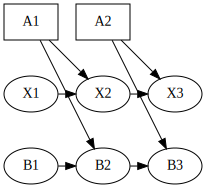

In [43]:
factored = gtsam.DiscreteBayesNet()
factored.add(state_prior)
factored.add(B[1], [], "1/0/0")
for k in range(1, N):
    factored.add(X[k+1], [X[k], A[k]], spec)
    factored.add(B[k+1], [A[k], B[k]], "".join([spec_b]*4))
show(factored, hints={"A":2, "X":1, "B":0}, boxes={A[1][0],A[2][0]})

You can see that under the transition models chosen, there are now two semi-independent Markov chains. In fact, as the action sequence is *given*, the chains are truly independent.

### Exercise
Note that  do you above model makes a number of strong statements about the nature of the worlds:
1. The next battery state does not depend on where we are in the world. This seems like an OK assumption. Still, can you think of situations where this is not a realistic assumptions?
2. The next state does not depend on the battery life. Maybe this is not so defensible: clearly, if the battery is empty the robot cannot move, and the next state is the same as the previous state. It is worthwhile to think about what you would change above to make a more realistic model of the world.

## GTSAM 101

> The GTSAM concepts used in this section, explained.

Above, we use the `gtsam.DiscreteBayesNet` class, and in particular these methods:

- `add(self:, key: Tuple[int, int], parents: List[Tuple[int, int]], spec: str) -> None`: adds a conditional with the same arguments as the `gtsam.DiscreteConditional` constructor.
- `at(self, i: int) -> gtsam.DiscreteConditional`: retrieves the $i^{th}$ conditional added.

We used a sleight of hand above to extend the battery depletion model to depend on the navigation action. The following is a but of python code that replicates our specification four times:

In [44]:
"".join([spec_b]*4)

'9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 '

We then made sure to specify the action *before* the previous battery state, so that the string above works out. Below we pretty-print to make verify this came out right:

In [45]:
pretty(gtsam.DiscreteConditional(B[2], [A[2], B[1]], "".join([spec_b]*4)))

A2,B1,full,half,empty
L,full,0.9,0.1,0
L,half,0,0.9,0.1
L,empty,0,0,1
R,full,0.9,0.1,0
R,half,0,0.9,0.1
R,empty,0,0,1
U,full,0.9,0.1,0
U,half,0,0.9,0.1
U,empty,0,0,1
D,full,0.9,0.1,0


Of course, it is entirely possible to make the battery model *dependent* on the action chosen.

Finally, a word about the graphs above. You might wonder, why these graphs come out so beautifully positioned, e.g., to indicate time from left to right. This was accomplished with the `hints` argument, which positions variables series at an appropriate height. Similarly, the `boxes` argument (which takes `gtsam.Keys`, not tuples) indicates which variables should considered as given.

These arguments are handled in the [`gtbook` library](https://gtbook.github.io/gtbook/), and are passed on in the appropriate format to the underlying GTSAM `dot` methods.